## Ethiopian Bank Reviews - Task 2: Sentiment & Thematic Analysis
# 
# **Objective**: Analyze sentiment and identify key themes in bank app reviews

In [1]:
# Import libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pathlib import Path
import json
from tqdm.auto import tqdm
# Ensure the parent directory of 'src' is in the Python path
sys.path.append(os.path.abspath('../'))
# Import from your modules
from src.sentiment.sentiment import SentimentAnalyzer
from src.sentiment.themes import ThemeAnalyzer

d:\Projects\Python\bank-app-reviews-analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup visualization
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### 1. Load Processed Data

In [3]:
# Load cleaned data from Task 1
input_path = "data/processed/all_banks_combined.csv"
reviews_df = pd.read_csv(input_path)

print(f"Loaded {len(reviews_df)} reviews")
display(reviews_df.head(2))

Loaded 815 reviews


,review_id,review,rating,date,bank,source
0,c1698da217f8f1f69ec3f269f2adaed3,"""Why don’t your ATMs support account-to-accoun...",4,2025-06-06,Commercial Bank of Ethiopia,Google Play
1,07bec0f87319f8e9e6541da2883b2916,what is this app problem???,1,2025-06-05,Commercial Bank of Ethiopia,Google Play


### 2. Sentiment Analysis

In [4]:
sentiment_analyzer = SentimentAnalyzer(model_name="distilbert-base-uncased-finetuned-sst-2-english")

# Analyze a sample first for testing
sample_reviews = reviews_df['review'].sample(5, random_state=42)
for review in sample_reviews:
    sentiment, score = sentiment_analyzer.analyze_review(review)
    print(f"Review: {review[:60]}...")
    print(f"Sentiment: {sentiment} (Confidence: {score:.2f})\n")

Review: cbe very active Bank I'm using CBE app very very satisfactio...
Sentiment: POSITIVE (Confidence: 0.99)

Review: bro the worst app made by human kind!! as a software enginee...
Sentiment: NEGATIVE (Confidence: 1.00)

Review: What's up I can't log in, what's wrong...
Sentiment: NEGATIVE (Confidence: 1.00)

Review: good give us plus...
Sentiment: POSITIVE (Confidence: 1.00)

Review: The Dashen Bank Super App has truly elevated my mobile banki...
Sentiment: POSITIVE (Confidence: 1.00)



#### Batch Analysis

In [5]:
# Analyze all reviews 
results = []
for review in tqdm(reviews_df['review'], desc="Analyzing sentiment"):
    results.append(sentiment_analyzer.analyze_review(review))
    
reviews_df[['sentiment', 'sentiment_score']] = pd.DataFrame(results, index=reviews_df.index)

Analyzing sentiment: 100%|██████████| 815/815 [00:12<00:00, 64.77it/s]


In [6]:
# Define the output directory
output_dir = Path("data/outputs")
output_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist

# Save results
reviews_df.to_csv(output_dir / "reviews_with_sentiment.csv", index=False)
print("Saved reviews with sentiment to:", output_dir / "reviews_with_sentiment.csv")

Saved reviews with sentiment to: data\outputs\reviews_with_sentiment.csv


 ### 3. Sentiment Visualization

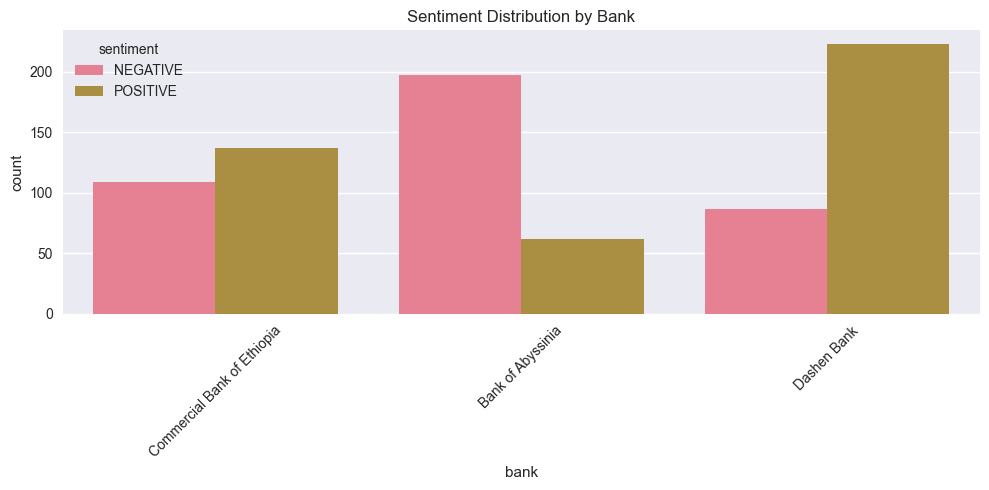

In [7]:
# Plot sentiment distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=reviews_df, x='bank', hue='sentiment')
plt.title('Sentiment Distribution by Bank')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("data/outputs/sentiment_distribution.png")
plt.show()

### 4. Thematic Analysis

In [11]:
import spacy
nlp = spacy.load("en_core_web_sm")

theme_analyzer = ThemeAnalyzer()

# Analyze themes per bank
theme_results = {}
for bank in reviews_df['bank'].unique():
    bank_reviews = reviews_df[reviews_df['bank'] == bank]
    themes = theme_analyzer.identify_themes(bank_reviews, bank)
    theme_results[bank] = themes
    
    print(f"\n🔍 Top Themes for {bank}:")
    for theme, count in themes['themes'].items():
        print(f"- {theme}: {count} reviews")


🔍 Top Themes for Commercial Bank of Ethiopia:
- Features: {'positive': 6, 'negative': 0} reviews
- UI/UX: {'positive': 30, 'negative': 8} reviews
- Performance: {'positive': 15, 'negative': 4} reviews
- Customer Support: {'positive': 1, 'negative': 1} reviews
- Security: {'positive': 3, 'negative': 0} reviews

🔍 Top Themes for Bank of Abyssinia:
- Performance: {'positive': 5, 'negative': 23} reviews
- UI/UX: {'positive': 11, 'negative': 29} reviews
- Features: {'positive': 3, 'negative': 1} reviews
- Customer Support: {'positive': 1, 'negative': 8} reviews
- Security: {'positive': 1, 'negative': 0} reviews

🔍 Top Themes for Dashen Bank:
- Performance: {'positive': 51, 'negative': 12} reviews
- UI/UX: {'positive': 69, 'negative': 7} reviews
- Security: {'positive': 18, 'negative': 0} reviews
- Features: {'positive': 7, 'negative': 0} reviews
- Customer Support: {'positive': 3, 'negative': 0} reviews


### 5. Theme Visualization

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


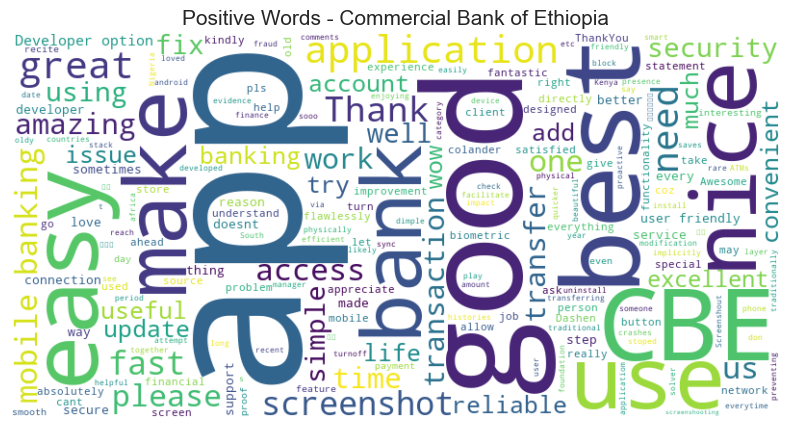

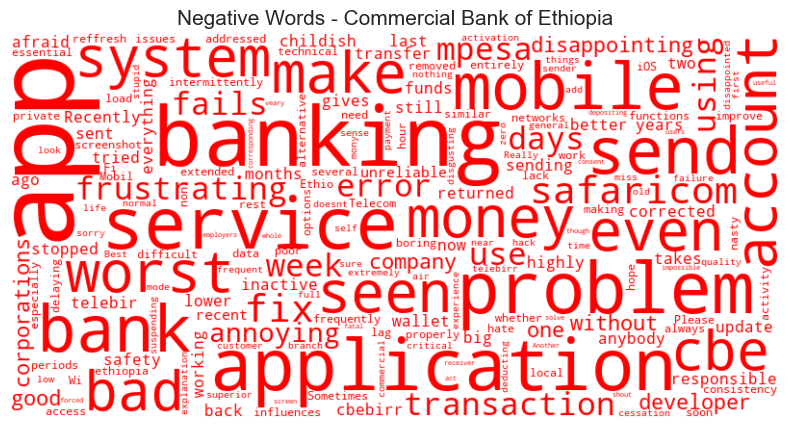

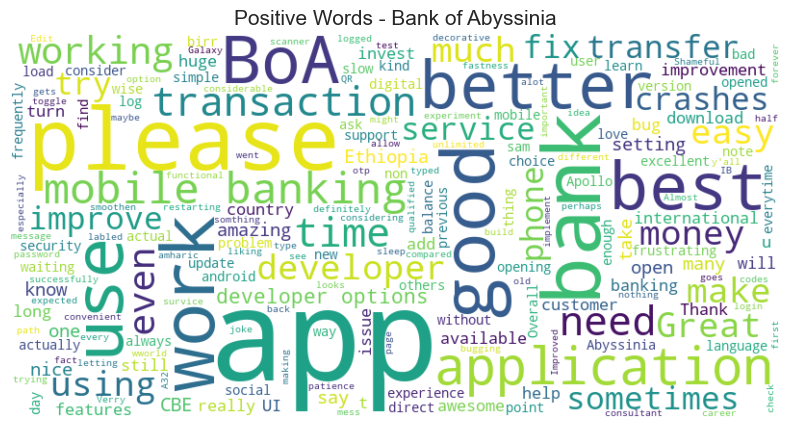

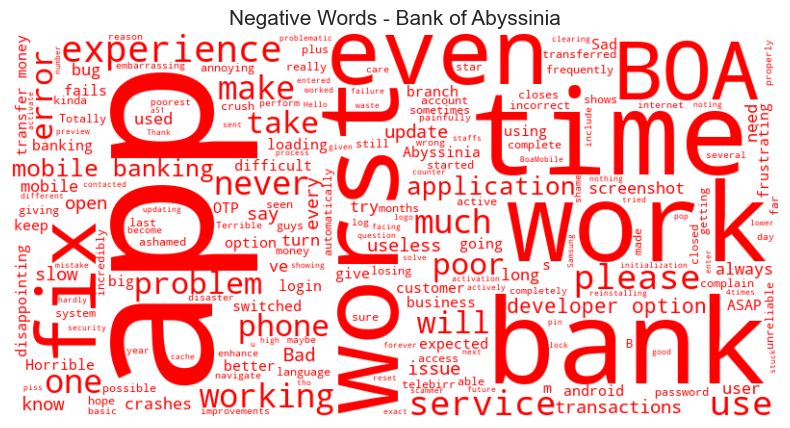

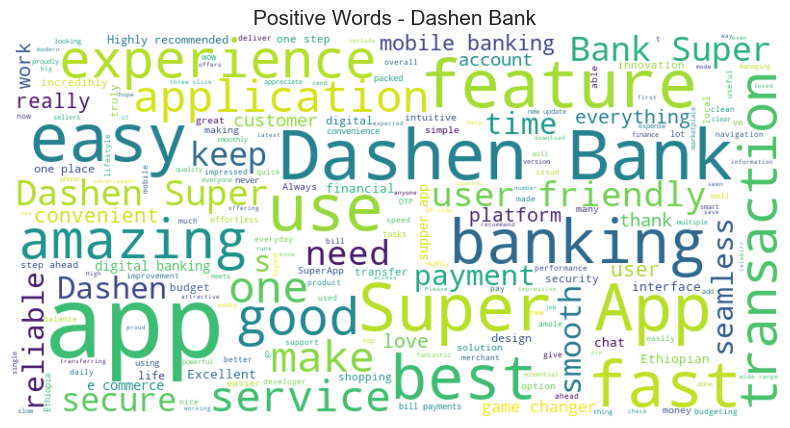

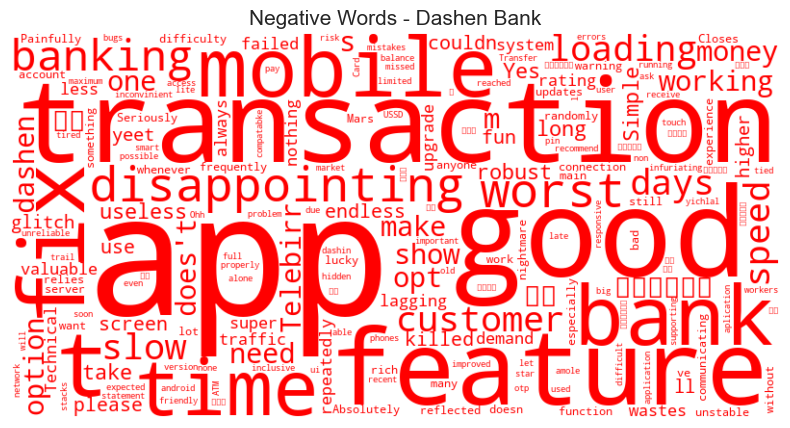

In [12]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Assuming reviews_df is already defined and loaded with reviews

# Function to classify sentiment
def classify_sentiment(review):
    score = sia.polarity_scores(review)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis
reviews_df['sentiment_label'] = reviews_df['review'].apply(classify_sentiment)

# Now you can proceed with generating insights or word clouds

# Function to define colors based on sentiment
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    sentiment = kwargs.get('sentiment', 'neutral')
    if sentiment == 'negative':
        return 'red'  # Color for negative words
    else:
        return 'black'  # Default color for positive words

# Generate word clouds for each bank, split by sentiment
for bank in reviews_df['bank'].unique():
    bank_reviews = reviews_df[reviews_df['bank'] == bank]

    # Separate positive and negative reviews
    positive_text = ' '.join(bank_reviews[bank_reviews['sentiment_label'] == 'positive']['review'])
    negative_text = ' '.join(bank_reviews[bank_reviews['sentiment_label'] == 'negative']['review'])

    # Generate word cloud for positive reviews
    positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.title(f'Positive Words - {bank}', size=15)
    plt.axis("off")
    plt.savefig(f"data/outputs/wordcloud_{bank.lower().replace(' ', '_')}_positive.png")
    plt.show()

    # Generate word cloud for negative reviews with custom color function
    negative_wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=lambda *args, **kwargs: 'red').generate(negative_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(negative_wordcloud, interpolation='bilinear')
    plt.title(f'Negative Words - {bank}', size=15)
    plt.axis("off")
    plt.savefig(f"data/outputs/wordcloud_{bank.lower().replace(' ', '_')}_negative.png")
    plt.show()

### 6. Combined Insights

In [22]:

def generate_insights(df, bank_name, theme_results):
    # Sentiment by rating
    sentiment_table = pd.pivot_table(
        df[df['bank'] == bank_name],
        values='review',
        index='rating',
        columns='sentiment_label',
        aggfunc='count',
        fill_value=0
    )

    # Top pain points
    if bank_name in theme_results and 'themes' in theme_results[bank_name]:
        pain_points = theme_results[bank_name]['themes']

        if isinstance(pain_points, dict):
            try:
                # Calculate total mentions (positive + negative) for each theme
                pain_points_with_count = {
                    k: v.get("positive", 0) + v.get("negative", 0)
                    for k, v in pain_points.items()
                    if isinstance(v, dict)
                }

                # Sort and get top 3
                pain_points_sorted = sorted(
                    pain_points_with_count.items(),
                    key=lambda x: x[1],
                    reverse=True
                )[:3]

            except Exception as e:
                raise ValueError(f"Error processing pain_points for {bank_name}: {pain_points}") from e
        else:
            raise ValueError(f"Expected pain_points to be a dictionary for {bank_name}, but got {type(pain_points)}")
    else:
        raise KeyError(f"{bank_name} not found in theme_results or themes not available.")

    return {
        "bank": bank_name,
        "sentiment_by_rating": sentiment_table.to_dict(),
        "top_pain_points": pain_points_sorted,
        "avg_sentiment_score": df[df['bank'] == bank_name]['sentiment_score'].mean()
    }




In [23]:

# Generate insights for all banks
all_insights = [generate_insights(reviews_df, bank, theme_results) for bank in reviews_df['bank'].unique()]

In [24]:
# Save insights
with open("data/outputs/bank_insights.json", "w") as f:
    json.dump(all_insights, f, indent=2)

# Display sample insights
print("Sample Insights for CBE:")
display(all_insights)

Sample Insights for CBE:


[{'bank': 'Commercial Bank of Ethiopia',
  'sentiment_by_rating': {'negative': {1: 17, 2: 4, 3: 1, 4: 3, 5: 2},
   'neutral': {1: 11, 2: 3, 3: 10, 4: 12, 5: 39},
   'positive': {1: 12, 2: 5, 3: 4, 4: 15, 5: 108}},
  'top_pain_points': [('UI/UX', 38), ('Performance', 19), ('Features', 6)],
  'avg_sentiment_score': 0.9748505814288689},
 {'bank': 'Bank of Abyssinia',
  'sentiment_by_rating': {'negative': {1: 75, 2: 2, 3: 3, 4: 0, 5: 3},
   'neutral': {1: 43, 2: 4, 3: 8, 4: 3, 5: 30},
   'positive': {1: 32, 2: 3, 3: 12, 4: 6, 5: 35}},
  'top_pain_points': [('UI/UX', 40),
   ('Performance', 28),
   ('Customer Support', 9)],
  'avg_sentiment_score': 0.9725004510529713},
 {'bank': 'Dashen Bank',
  'sentiment_by_rating': {'negative': {1: 11, 2: 6, 3: 0, 4: 2, 5: 3},
   'neutral': {1: 9, 2: 4, 3: 4, 4: 7, 5: 38},
   'positive': {1: 10, 2: 4, 3: 7, 4: 9, 5: 196}},
  'top_pain_points': [('UI/UX', 76), ('Performance', 63), ('Security', 18)],
  'avg_sentiment_score': 0.9898627973371936}]

### 7. Export Notebook Results

In [27]:
# Save notebook output
import os
!pip install nbformat
from nbformat import v4, write

# Ensure notebooks directory exists
os.makedirs("notebooks", exist_ok=True)

# Create a new notebook
notebook = v4.new_notebook(
    cells=[
        v4.new_markdown_cell("# Ethiopian Bank Reviews Analysis"),
        v4.new_code_cell("print('Hello from saved notebook!')")
    ]
)

notebook_path = "notebooks/Sentiment_and_Thematic_Analysis.ipynb"
with open(notebook_path, "w", encoding="utf-8") as f:
    write(notebook, f)  # Use write instead of writes

print(f"Notebook successfully saved to {notebook_path}")

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached jsonschema-4.24.0-py3-none-any.whl.metadata (7.8 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached jsonschema_specifications-2025.4.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached referencing-0.36.2-py3-none-any.whl.metadata (2.8 kB)
  Using cached rpds_py-0.25.1-cp310-cp310-win_amd64.whl.metadata (4.2 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached fastjsonschema-2.21.1-py3-none-any.whl (23 kB)
Using cached jsonschema-4.24.0-py3-none-any.whl (88 kB)
Using cached attrs-25.3.0-py3-none-any.whl (63 kB)
Using cached jsonschema_specifications-2025.4.1-py3-none-any.whl (18 kB)
Using cached referencing-0.36.2-py3-none-any.whl (26 kB)
Using cached rpds_py-0.25.1-cp310-cp310-win_amd64.whl (231 kB)

   ----------- ---------------------------- 2/7 [attrs]
   ----------------- ------------